In [ ]:
from flashdiv.flows.trainer import FlowTrainer
from flashdiv.flows.gnn import EGNN_dynamics
from flashdiv.flows.architectures import VelocityFlowLJ
import torch
import torch.nn as nn
import numpy as np
import sys
from einops import rearrange, repeat, reduce
from torch.func import jvp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import math


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
class BaseDistribution(torch.nn.Module):
    def __init__(self, nparticles=4, dim=2, batch_size=10, device='cuda'):
        super(BaseDistribution, self).__init__()
        self.batch_size = batch_size
        self.nparticles = nparticles
        self.dim = dim
        self.param = torch.nn.Parameter(torch.randn(batch_size,nparticles,dim).to(device))

    @property
    def state(self):
        return self.param

    def potential(self, x):
        pass

    def forward(self, x=None):
        return self.log_prob(x)

    def log_prob(self, x=None):
        if x is None:
            x = self.param
        return -self.potential(x)

    def grad_log_prob(self, x=None):
        if x is None:
            x = self.param
        x.requires_grad_(True)
        with torch.enable_grad():
            return  -torch.autograd.grad(-self.potential(x), x,
                                         torch.ones(x.shape[0]).to(x.device), create_graph=True)[0]

    def neg_force_clipped(self, x=None, max_val=80):
        if x is None:
            x = self.param
        return torch.clip(self.grad_log_prob(x),-max_val,max_val)

    def reset_parameters(self):
        self.param.data = torch.randn(self.batch_size,self.nparticles,self.dim).to(self.param.device)

class LJ(BaseDistribution):
    def __init__(self, nparticles=10, dim=3, batch_size=10,
                  device="cuda", boxlength=None, kT=1,
                  epsilon=1., sigma=1., cutoff=None, shift=True,
                  periodic=False, spring_constant=0.001):
        super(LJ, self).__init__(nparticles=nparticles, dim=dim, batch_size=batch_size, device=device)
        self.kT = kT
        self.epsilon=epsilon
        self.sigma=sigma
        self.cutoff=cutoff
        self.shift=shift
        self.boxlength=boxlength
        self.periodic=periodic
        self.spring_constant=spring_constant


    def potential(self,particle_pos, min_dist=None, turn_off_harmonic=False):
        """
        Calculates Lennard_Jones potential between particles
        Arguments:
        particle_pos: A tensor of shape (n_particles, n_dimensions)
        representing the particle positions
        boxlength: A tensor of shape (1) representing the box length
        epsilon: A float representing epsilon parameter in LJ
        Returns:
        total_potential: A tensor of shape (n_particles, n_dimensions)
        representing the total potential of the system
        """
        pair_vec = self.pair_vec(particle_pos)
        distances = torch.linalg.norm(pair_vec.float(), axis=-1)
        rem_dims = distances.shape[:-2]
        n = distances.shape[-1]
        distances = distances.flatten(start_dim=-2)[...,1:].view(*rem_dims,n-1, n+1)[...,:-1].reshape(*rem_dims,n, n-1)
        scaled_distances = distances
        if min_dist is not None:
            scaled_distances = torch.clamp(scaled_distances,min=min_dist)
        distances_inverse = 1/scaled_distances
        if self.cutoff is not None:
            distances_inverse = distances_inverse-(distances >self.cutoff)*distances_inverse
            pow_6 = torch.pow(self.sigma*distances_inverse, 6)
            if self.shift:
                pow_6_shift = (self.sigma/self.cutoff)**6
                pair_potential = self.epsilon * 4 * (torch.pow(pow_6, 2)
                                        - pow_6 - pow_6_shift**2+pow_6_shift)
            else:
                pair_potential = self.epsilon * 4 * (torch.pow(pow_6, 2)
                                        - pow_6)
        else:
            pow_6 = torch.pow(self.sigma*distances_inverse, 6)
            pair_potential = self.epsilon * 4 * (torch.pow(pow_6, 2)
                                        - pow_6)
        pair_potential = pair_potential *distances_inverse*distances
        total_potential = torch.sum(pair_potential,axis=(-1,-2))/2
        if not self.periodic and not turn_off_harmonic:
            total_potential += self.harmonic_potential(particle_pos)
        return total_potential


    def log_likelihood(self,particle_pos, min_dist=None):
        """
        heat version of logprob
        """
        return - self.potential(particle_pos, min_dist=min_dist) / self.kT


    def harmonic_force(self,particle_pos):
        com = torch.mean(particle_pos,axis=-2,keepdim=True)
        rel_pos = particle_pos - com
        harm_f = -self.spring_constant*rel_pos
        return harm_f

    def harmonic_potential(self,particle_pos):
        com = torch.mean(particle_pos,axis=-2,keepdim=True)
        rel_pos = particle_pos - com
        harm_pot = 0.5*self.spring_constant*(rel_pos)**2
        return harm_pot.sum(axis=(-1,-2))

    def grad_log_prob(self, x=None):
        if x is None:
            x = self.param
        return self.force(x)

    def force(self,particle_pos,min_dist=None):
        """
        Calculates Lennard_Jones force between particles
        Arguments:
            particle_pos: A tensor of shape (n_particles, n_dimensions)
        representing the particle positions
        box_length: A tensor of shape (1) representing the box length
        epsilon: A float representing epsilon parameter in LJ

        Returns:
            total_force_on_particle: A tensor of shape (n_particles, n_dimensions)
        representing the total force on a particle
         """
        eps = self.epsilon
        sig = self.sigma
        pair_vec = self.pair_vec(particle_pos)
        distances = torch.linalg.norm(pair_vec.float(), axis=-1)
        scaled_distances = distances + (distances == 0)
        if min_dist is not None:
            scaled_distances = torch.clamp(scaled_distances,min=min_dist)
        distances_inverse = 1/scaled_distances
        if self.cutoff is not None:
            distances_inverse = distances_inverse-(distances >self.cutoff)*distances_inverse
            pow_6 = torch.pow(sig*distances_inverse, 6)
            force_mag = eps * 24 * (2 * torch.pow(pow_6, 2)
                                    - pow_6)*sig*distances_inverse
        else:
            pow_6 = torch.pow(sig/scaled_distances, 6)
            force_mag = eps * 24 * (2 * torch.pow(pow_6, 2)
                                    - pow_6)*sig*distances_inverse
        force_mag = force_mag * distances_inverse
        force = -force_mag.unsqueeze(-1) * pair_vec
        total_force = torch.sum(force, dim=1)
        if not self.periodic:
            total_force += self.harmonic_force(particle_pos)
        return total_force

    def pair_vec(self,particle_pos):
        pair_vec = (particle_pos.unsqueeze(-2) - particle_pos.unsqueeze(-3))
        if self.periodic:
            to_subtract = ((torch.abs(pair_vec)> 0.5 * self.boxlength)
                        * torch.sign(pair_vec) * self.boxlength)
            pair_vec -= to_subtract
        return pair_vec

    def g_r(self,particle_pos, bins=100):
        dim = particle_pos.shape[-1]
        pair_vec = self.pair_vec(particle_pos)
        nsamples = len(pair_vec)
        nparticles = pair_vec.shape[1]
        distances = torch.linalg.norm(pair_vec.float(), axis=-1)
        # remove diagonal zeros
        rem_dims = distances.shape[:-2]
        distances = distances.flatten(start_dim=-2)[...,1:].view(
        *rem_dims,nparticles-1, nparticles+1)[...,:-1].reshape(*rem_dims,nparticles, nparticles-1)
        if self.periodic:
            counts,bins = np.histogram(distances.detach().cpu().numpy(),bins=bins)
            if dim == 2:
                bulk_density = nparticles/(self.boxlength**2)
                areas = math.pi*(bins[1:]**2-bins[:-1]**2)
            elif dim == 3:
                bulk_density = nparticles/(self.boxlength**3)
                areas = 4*math.pi*bins[1:]**2
            g_r = counts/(nparticles-1)**2/nsamples/areas/bulk_density
        else:
            com = torch.mean(particle_pos,axis=1)
            dist_from_com = torch.linalg.norm(particle_pos-com.unsqueeze(1),axis=-1)
            com_atom = torch.min(dist_from_com,axis=1)[1]
            distances = distances[torch.arange(distances.shape[0]),com_atom].flatten()
            counts,bins = np.histogram(distances.detach().cpu().numpy(),bins=bins)
            bulk_density = nparticles/(4/3*math.pi*(self.boxlength/2)**3)
            areas = 4*math.pi*((bins[:-1]+bins[1:])/2)**2*(bins[1:]-bins[:-1])
            g_r = counts/nsamples/areas/bulk_density
        return bins, g_r

In [ ]:
simulation_data = np.load("/mnt/ssd/flow_matching/flashdiv/lj/lj_1.0.npy")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nbparticles = 9
dim = 2

In [50]:
simulation_data[0]

array([[[-0.35087594, -1.0373473 ],
        [ 1.855462  , -1.4196774 ],
        [-1.0442152 ,  0.00980038],
        ...,
        [ 1.3962263 , -0.35816735],
        [-2.0245402 ,  0.67618155],
        [ 1.4771411 ,  0.82725513]],

       [[-0.612633  , -0.3145281 ],
        [ 0.77032614, -1.3352741 ],
        [-2.1499033 ,  1.5400754 ],
        ...,
        [ 2.3771954 ,  1.1377494 ],
        [-1.0576419 ,  0.7862505 ],
        [ 3.150319  , -0.24380791]],

       [[-1.4810873 ,  1.316281  ],
        [-1.528776  ,  0.15296762],
        [-0.84322697, -1.0595229 ],
        ...,
        [ 1.8894421 , -0.79464775],
        [-0.51296926, -2.0411692 ],
        [ 0.43370238, -0.3534445 ]],

       ...,

       [[-1.8056184 , -0.4755971 ],
        [ 1.5253836 , -0.07576893],
        [ 0.6051744 ,  0.37655693],
        ...,
        [ 0.61613387, -0.826821  ],
        [-0.5284329 , -0.05139308],
        [-1.2207687 ,  0.79981583]],

       [[ 0.5988002 ,  1.6470671 ],
        [ 1.9634635 ,  0.14

In [10]:
lj= LJ(nbparticles, dim, kT=1.0, boxlength=None, periodic=False, spring_constant=0.5)

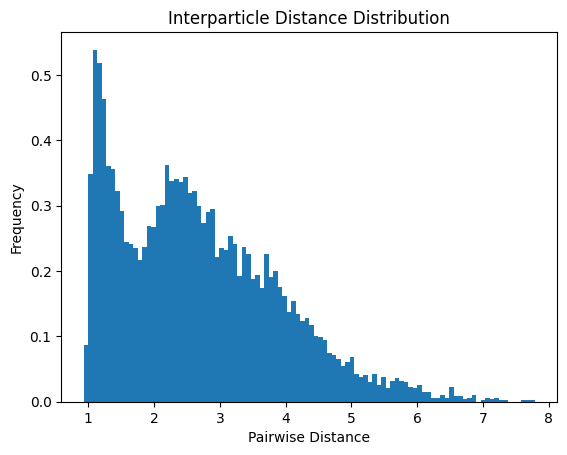

torch.Size([200, 9, 2])

In [7]:
x = torch.tensor(simulation_data[:,-1], device=device).reshape(-1, nbparticles, dim)
dists = torch.norm(x.unsqueeze(2) - x.unsqueeze(1), dim=-1)  # shape (batch, N, N)
mask = ~torch.eye(x.shape[1], device=x.device).bool()
dists = dists[:, mask].reshape(-1)
plt.hist(dists.cpu().numpy(), bins=100, density=True)
plt.xlabel("Pairwise Distance")
plt.ylabel("Frequency")
plt.title("Interparticle Distance Distribution")
plt.show()
x.shape

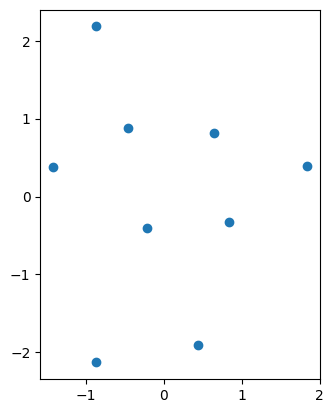

In [ ]:
plt.scatter(x[0, :, 0].cpu().numpy(), x[0, :, 1].cpu().numpy())
#equal x and y axis
plt.xlim(-2, 2)
plt.ylim(-2, 2)

(array([1.37477417e-05, 0.00000000e+00, 1.37477417e-05, 1.37477056e-05,
        1.37477417e-05, 2.74954833e-05, 1.09981933e-04, 1.64972900e-04,
        3.16198058e-04, 5.91152116e-04, 9.62341916e-04, 1.60848577e-03,
        2.35086074e-03, 3.38194445e-03, 4.56425023e-03, 6.15898826e-03,
        7.95993198e-03, 1.12181572e-02, 1.42151649e-02, 1.81882384e-02,
        2.13914860e-02, 2.68355917e-02, 3.07261825e-02, 3.70226683e-02,
        4.39927445e-02, 4.98905218e-02, 5.46060298e-02, 6.25659518e-02,
        6.95497908e-02, 7.38940872e-02, 8.05067421e-02, 8.59371049e-02,
        8.99102009e-02, 9.40482698e-02, 9.68528082e-02, 1.00262247e-01,
        1.02241921e-01, 1.01293327e-01, 1.01293294e-01, 1.02998080e-01,
        9.72239652e-02, 9.62203808e-02, 9.23848239e-02, 8.94840504e-02,
        8.46034912e-02, 7.75647584e-02, 7.42103094e-02, 6.95498250e-02,
        6.37894376e-02, 5.90740459e-02, 5.48947324e-02, 4.75121329e-02,
        4.37728094e-02, 4.01158575e-02, 3.54279302e-02, 3.117987

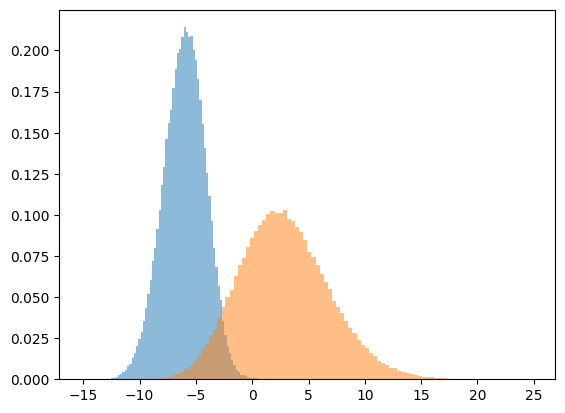

In [12]:
pot = lj.potential(torch.tensor(simulation_data, device=device), turn_off_harmonic=True).flatten()
pot_harm = lj.potential(torch.tensor(simulation_data, device=device), turn_off_harmonic=False).flatten()
plt.hist(pot.cpu().numpy(), bins=100, density=True, alpha=0.5, label='LJ Potential')
plt.hist(pot_harm.cpu().numpy(), bins=100, density=True, alpha=0.5)
#plt.hist((pot - pot_harm).cpu().numpy(), bins=100, density=True, alpha=0.5, label='LJ Potential Harmonic')


In [9]:
lj.potential(torch.tensor(simulation_data[0,0]))

tensor(-6.7484)

In [56]:
simulation_data[0,10,0,1]


-0.15134329

In [7]:
x.shape

torch.Size([200, 9, 2])

In [12]:
# Replace 'model.ckpt' with the path to your actual checkpoint file
checkpoint_path = "/mnt/ssd/flow_matching/20250522_lj9_flowtraining/flow_model_lj2_2d_1.0_nb_data_200000_batch_size_256_epochs_500_lr_0.0001/lightning_logs/version_0/checkpoints/test.ckpt"
flow_model = EGNN_dynamics()
#flow_model = VelocityFlowLJ(dim=int(nbparticles * dim), hidden_dim=int(6 * dim * nbparticles), num_layers=6)
# Load the model
trainer = FlowTrainer.load_from_checkpoint(checkpoint_path, flow_model=flow_model)

/home/sherryli/xsli/softwares/anaconda3/envs/lightning/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'flow_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['flow_model'])`.


In [18]:
model = trainer.flow_model
model = model.to(device)
rand = torch.randn(100, nbparticles, dim).to(device)
sample, logp = model.sample_logprob(rand)

In [4]:
# Replace 'model.ckpt' with the path to your actual checkpoint file
checkpoint_path = "/mnt/ssd/flow_matching/20250522_lj9_flowtraining/flow_model_lj9_2d_1.0_nb_data_200000_batch_size_256_epochs_500_lr_0.0001/lightning_logs/version_1/checkpoints/epoch=499-step=312500.ckpt"
flow_model9 = EGNN_dynamics()
# Load the model
trainer9 = FlowTrainer.load_from_checkpoint(checkpoint_path, flow_model=flow_model9)
model9 = trainer9.flow_model
model9 = model9.to(device)

/home/sherryli/xsli/softwares/anaconda3/envs/lightning/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'flow_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['flow_model'])`.


In [ ]:
def test_time_sensitivity(model):
    xs = torch.tensor([[[0.0, 0.0], [1.0, 0.0]]], dtype=torch.float32, device=device)  # Example positions for 2 particles in 2D
    t1 = torch.tensor([0.0]).to(device)
    t2 = torch.tensor([1.0]).to(device)
    v1 = model(xs, t1)
    v2 = model(xs, t2)
    print("Velocity difference due to time:", (v1 - v2).norm().item())


In [12]:
test_time_sensitivity(model9)
test_equivariance(model9)

Velocity difference due to time: 0.8210055828094482
[Rotation equivariance error]: 5.006790e-06
[Permutation equivariance error]: 5.722046e-06


In [23]:
device

device(type='cuda')

In [19]:
print(logp)

tensor([ 1.5078,  1.5521,  1.4037,  1.5536,  1.4396,  1.3205,  0.8629,  1.4310,
         1.3169,  1.5232,  1.3907,  1.0839,  1.4425,  1.4074,  1.3937,  1.1761,
         1.6170,  1.5459,  1.4187,  1.6132,  1.4218,  1.2913,  0.8966,  1.4887,
         1.4867, -0.7427,  1.5845,  1.4020,  1.4031,  1.4236,  1.4171,  0.8106,
         1.4065,  1.4225,  1.3881,  1.4253,  1.3932,  1.5957,  1.3955,  1.4024,
         1.0974,  1.4415,  0.5753,  1.4356,  1.6064,  0.6642,  1.4376,  1.3928,
         1.4007,  1.6060,  1.4221,  1.5125,  0.7840,  1.4512,  1.4249,  1.4280,
         1.4121,  1.2776,  1.4237,  1.3614,  1.4121,  1.4232,  1.4249,  1.2838,
         1.1983,  1.5477,  1.4093,  0.7349,  1.4126,  1.4128,  1.4201,  1.5296,
         0.6998,  1.4143,  1.3579,  1.4144,  1.6300,  1.4955,  0.7138, -1.1111,
         1.3911,  1.4101,  1.4680,  1.4223,  1.4582,  1.4150,  1.4386,  1.4325,
         1.5423,  1.4065,  1.4146,  1.4317,  1.6071,  1.4027,  0.1637,  1.3618,
         1.4355,  1.4495,  1.4165,  1.41

In [20]:
lj = LJ(nbparticles, dim, kT=1.0, boxlength=100)

In [21]:
pot = lj.potential(sample)
pot

tensor([ 7.2199e+00,  8.4251e+00,  2.8310e+00,  7.9133e+00,  5.2161e+00,
         6.1862e-01,  1.5743e+00,  3.1972e+00,  1.3952e+00,  7.5210e+00,
         3.9632e+00,  8.7670e-01,  6.8425e+00,  4.4126e+00,  3.2516e+00,
         2.8442e+00,  1.4016e+01,  1.5176e+01,  1.8948e+00,  1.2612e+01,
         3.8249e+00,  1.2889e+00, -1.7979e-02,  6.6197e+00,  8.7448e+00,
         1.9617e+01,  9.1396e+00,  7.3351e+00,  3.4113e+00,  5.4071e+00,
         5.7960e+00, -1.7972e-01,  3.5144e+00,  2.1165e+00,  3.3395e+00,
         4.7364e+00,  3.7653e+00,  9.2161e+00,  4.1034e+00,  2.7294e+00,
         5.7761e-01,  5.5454e+00, -4.7327e-01,  2.5792e+00,  1.7234e+01,
         1.0442e+00,  5.3367e+00,  4.7870e+00,  4.1135e+00,  1.0596e+01,
         4.5388e+00,  7.7621e+00, -2.7838e-01,  6.4729e+00,  4.1871e+00,
         2.5607e+00,  4.1325e+00,  5.2078e+00,  4.8110e+00,  2.4587e+00,
         2.4419e+00,  5.8702e+00,  1.5862e+00,  2.8046e+00,  4.9332e-01,
         8.0139e+00,  3.6364e+00,  3.0426e-01,  3.5

/tmp/ipykernel_523775/943713022.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(sample, device=device).reshape(-1, nbparticles, dim)


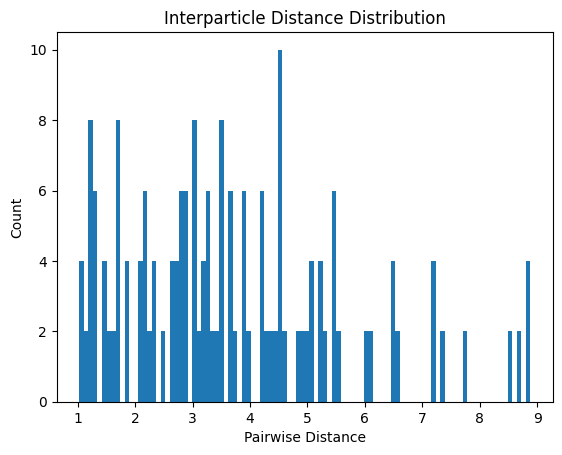

In [22]:
x = torch.tensor(sample, device=device).reshape(-1, nbparticles, dim)
dists = torch.norm(x.unsqueeze(2) - x.unsqueeze(1), dim=-1)  # shape (batch, N, N)
mask = ~torch.eye(x.shape[1], device=x.device).bool()
dists = dists[:, mask].reshape(-1)
plt.hist(dists.cpu().numpy(), bins=100)
plt.xlabel("Pairwise Distance")
plt.ylabel("Count")
plt.title("Interparticle Distance Distribution")
plt.show()

In [38]:
pot = pot[pot < 100]